#Maximum Margin Classifiers - The Support Vector Machine

<p>Given a labeled scatter plot, such as the one below, the best way to classify points of different classes is to find a hyper-plane (straight line in the 2-d case) that separates the two classes.</p>

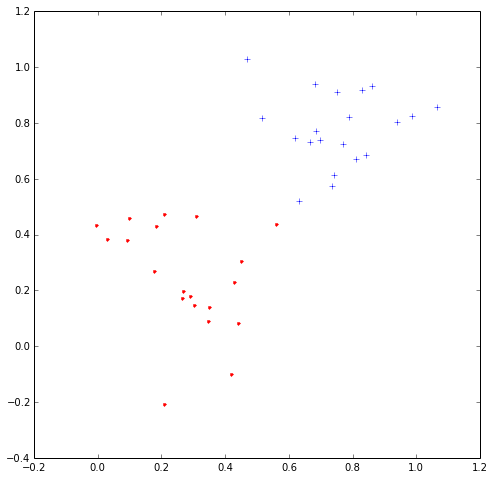

In [2]:
import course_utils as bd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
reload(bd)
%matplotlib inline

#generate data
m = [[0.25,0.25], [0.75,0.75]]; s = 0.025; n=20
X1 = pd.DataFrame(np.random.multivariate_normal([m[0][0], m[0][1]], [[s,0],[0,s]], n), columns=['x1','x2'])
X2 = pd.DataFrame(np.random.multivariate_normal([m[1][0], m[1][1]], [[s,0],[0,s]], n), columns=['x1','x2'])

plt.figure(figsize = (8, 8))

#Plot data and any hyper-plane that separates the data
plt.plot(X1['x1'], X1['x2'],'r.')
plt.plot(X2['x1'], X2['x2'],'b+')


<p>The issue with looking for just any separating line is that an infinite number of lines might qualify, even if the space between classes is quite small. The following shows the same data above along with many qualifying lines.</p>

(0, 1)

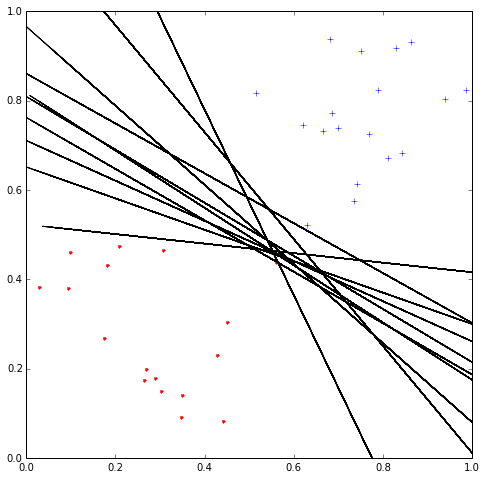

In [6]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)

#Plot data and any hyper-plane that separates the data
plt.plot(X1['x1'], X1['x2'],'r.')
plt.plot(X2['x1'], X2['x2'],'b+')

#We'll use a brute force search for this, but starting from an intelligent starting point
success = 0; ws = np.array([1, 1]); t = 1
while (success < 10):
    #Randomly perturbate the starting point, check to see if it seprates the points
    w_i = ws + np.random.normal(0, 1, 2); t_i = t + np.random.normal(0, 1, 1)
    if not ((sum((X1.dot(w_i) - t_i)>0)) or (sum((X2.dot(w_i) - t_i)<0))):
        bd.plot_dec_line(X1['x1'].min(), X2['x1'].max(), w_i[0], w_i[1],-1*t_i, 'k-', 't')
        success += 1

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
        

##Getting the Maximum Margin
<p>With so many hyperplane options, we need a principled way to choose an optimal separating line. Intuitively, we want a line that is simultaneously as far away from the positive instances as it is from the negative instances. In a sense, we want it to be in the middle of the empty region separating the classes. We can formalize this by searching for a hyperplane that maximizes the margin between the positive and negative classes.<br><br>

<b>Some Definitions</b>
<ul>
    <li>$W=<W^1,...W^k>$ is a weight vector, $X=<X^1,...X^k>$ is a vector of features </li>
    <li>The separating hyperplane is defined by the line: $W \cdot X+t=0$</li>
    <li>The vector $W$ is called the "normal vector" to the line, and is perpendicular to it.
    <li>The distance between any point $X_i$ and the line is given by: $\frac{W \cdot X_i+t}{\|W\|_2}$</li>
</ul>
<br>
<i>(How did we get that formula for the line, you ask??</i><br><br>
Let $Q$ be a point on the line $W \cdot X+t=0$, and let $W$ originate from $Q$. The distance from $X_i$ to the line is equal to the projection of the vector $\vec{QX_i}$ onto $W$. The distance $d$ is given then by the projection formula:<br>
<center>$d = \frac{W \cdot \vec{QX_i}}{\|W\|_2} = \frac{W \cdot X_i - W \cdot Q}{\|W\|_2} = \frac{W \cdot X_i+t}{\|W\|_2}$ </center><br>

The last bit comes from the fact that $W \cdot Q = t$ since $Q$ is on the line.<br><br>

<b>Constraining the Problem</b><br><br>
By adding contraints to the problem we make it easier to solve. Let $M^+$ and $M^-$ be the distances from the closest positive and negative point to the line. We are free to rescale $t$, $\|W\|_2$, $M^+$ and $M^-$ , so we do the following:<br><br>
<center>$M^+ = M^- = m = 1$</center><br><br>
With this constraint, the margin then becomes $\frac{2m}{\|W\|_2}$. Maximizing the margin then is equivalent to minimizing $\|W\|_2$, or more conveniently, $\frac{1}{2}\|W\|_2$.
</p>

##Defining the Optimization Problem

<p>

With perfectly separable data, we then define the following objective function.<br><br>

<center>$W^*,t^* = \underset{W,t} {\mathrm{argmin}}\frac{1}{2}\|W\|_2^2$  $\,\,\,\,\,$   subject to $y_i(W\cdot X_i + t) \geq 1$</center>
<br>
<br>
We can transform this using the method of Langrange multipliers. For each constraint we introduce a multipler $\alpha_i$, which results in the following Lagrange function:<br><br>
<center>$\Lambda(w,t,\alpha_i,...\alpha_n)=\frac{1}{2}\|W\|_2^2-\sum\limits_{i=1}^n\alpha_i(y_i(W\cdot X_i+t)-1)$</center>
<br>
<br>
The optimal hyper-plane is a saddle point of $\Lambda(w,t,\alpha_i,...\alpha_n)$. An interesting consequence of this formula is that there is a "dual-form," where we eliminate $W$ and $t$ and formulate the problem completely in terms of the Lagrange multipliers $\alpha_i$. The dual-form is:<br><br>

<center>$\underset{\alpha_1,...,\alpha_n} {\mathrm{argmax}}\sum\limits_{i=1}^n \alpha_i - \frac{1}{2} \sum\limits_{i=1}^n \sum\limits_{j=1}^n \alpha_i \alpha_j y_i y_j X_i\cdot X_j$
</center>
<center>subject to $\alpha_i\geq 0$ and $\sum\limits_{i=1}^n \alpha_i y_i = 0$</center>
<br>
<br>
The significance of the dual form is that searching for the optimal plane is equivalent to searching for the <i>support vectors</i>, which are the points that lie on the margin planes, and mathematically, are the points with non-zero Langrange multipliers. The decision boundary can be found using:<br><br>
<center>$W=\sum\limits_{X \in SV} \alpha_i y_i X_i$</center>
<br>
<br>

Now let's stop beating around the bush and actually build one! (note one important tip, with SVM's we generally encode a binary outcome as $[-1, 1]$ and not $[0, 1]$).

</p>

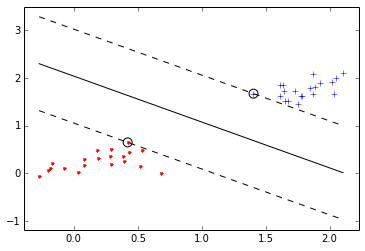

In [7]:
from sklearn import svm
import course_utils as bd
import pandas as pd
reload(bd)

m = [[0.25,0.25],[1.75,1.75]]; s = 0.05; n=20
X1=pd.DataFrame(np.random.multivariate_normal([m[0][0],m[0][1]],[[s,0],[0,s]],n), columns=['x1','x2'])
X2=pd.DataFrame(np.random.multivariate_normal([m[1][0],m[1][1]],[[s,0],[0,s]],n), columns=['x1','x2'])
X1['Y'] = -1 * np.ones(X1.shape[0]); X2['Y'] = 1 * np.ones(X2.shape[0])
dat = X1.append(X2, ignore_index=True)


my_svm = svm.SVC(kernel='linear')
my_svm.fit(dat[['x1','x2']], dat['Y'])

bd.plotSVM(dat[['x1','x2']], dat['Y'], my_svm)

In [12]:
my_svm.support_vectors_.dot(my_svm.coef_[0])+my_svm.intercept_

array([-1.00000005,  1.00000008])

<p>In the above we plot the optimal linear hyper-plane $W$ and also the hyper-planes that define the margin. Circled are the support vectors.<br><br>

Once we have found $W$ and $t$, classification of a point $X$ is defined as:<br><br>
<center>$f(X) = sign(W\cdot X + t)$</center><br><br>
which is just the sign of the distance between $X$ and the optimal hyper-plane.<br><br>

In the above scenarios we identified an optimal separating hyper-plane for data that is cleanly separated by a decision boundary. This is seldom the case in real data, so we need to adapt our formulation to allow for such cases.
</p>

##The Soft Margin Classifier

<p>Let $\xi_i = [\xi_i]_+ = [1- y_i(W\cdot X_i+t)]_+$ be the distance between a wrongly classified point $X$ and the optimal margin plane $y_i(W\cdot X_i+t)=1$, where $[1-z]_+ = max(0,1-z)$. This last function is also known as the <i>hinge function</i>. We can then redefine our optimization problem to allow for some misclassification of our training points. Specifically,:<br><br>

<center>$W^*,t^* = \underset{W,t} {\mathrm{argmin}}\frac{1}{2}\|W\|_2^2 + C\sum\limits_{i=1}^n\xi_i$</center>  
<center>subject to $y_i(W\cdot X_i + t) \geq 1 - \xi_i$</center><br><br>

It is often useful to write this as:
<center>$W^*,t^* = \underset{W,t} {\mathrm{argmin}}\;\lambda\|W\|_2^2 + \sum\limits_{i=1}^n [1- y_i(W\cdot X_i+t)]_+$</center><br><br>
where $\lambda = \frac{1}{2C}$. When we view the optimization problem in the above light, we can connect this back to ERM. The second term defines the training error, or the <i>hinge loss</i> of the problem. Our goal is to minimize this loss function while minimizing $W$, which in turn maximizes the margin.


</p>

##Example Soft Margin

<p>When we presented the soft margin version of the SVM, we also introduced a new term $C$ which controls the amount of error we can tolerate (or conversely, the size of the margin). $C$ is thus a free parameter that we must choose to get the right fit. One way to think about it is as $C$ increases we increase the size of the 2nd term in our optimization function. This means we become <i>less</i> tolerant of training errors (and we thus decrease the size of the margin).


</p>

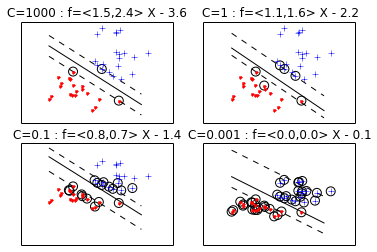

In [20]:
from sklearn import svm
import course_utils as bd
import pandas as pd
reload(bd)


#Generate noisier data than the last example
m = [[0.25,0.25],[1.25,1.25]]; s = 0.35; n=20
X1=pd.DataFrame(np.random.multivariate_normal([m[0][0],m[0][1]],[[s,0],[0,s]],n), columns=['x1','x2'])
X2=pd.DataFrame(np.random.multivariate_normal([m[1][0],m[1][1]],[[s,0],[0,s]],n), columns=['x1','x2'])
X1['Y'] = -1 * np.ones(X1.shape[0]); X2['Y'] = 1 * np.ones(X2.shape[0])
dat = X1.append(X2, ignore_index=True)


#Now plot for different levels of C

fig = plt.figure()
c_s = [ 1000, 1, 10e-2, 10e-4 ] 
for i,c in enumerate(c_s):
    my_svm = svm.SVC(kernel='linear', C=c)
    my_svm.fit(dat[['x1','x2']], dat['Y'])
    w = my_svm.coef_[0]
    t = my_svm.intercept_
    if t<0:
        sign = '-'
    else:
        sign = '+'
    ax = fig.add_subplot(2, 2, i+1)
    plt.title('C={} : f=<{},{}> X {} {}'.format(c, round(w[0],1), round(w[1],1), sign,np.abs(round(t,1))))
    bd.plotSVM(dat[['x1','x2']], dat['Y'], my_svm)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

<p>As we increase $C$, we can see that the norm of $W$ increases and the number of support vectors identified shrinks. 
</p>

#SVM vs. Logistic Regression

<p>Both SVM and Logistic Regression finds linear separating hyper-planes of the form $class(X)=f(W\cdot X+t)$.

</p>

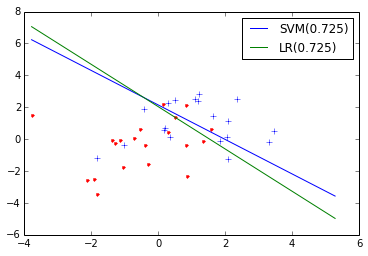

In [56]:
from sklearn import svm, linear_model
import course_utils as bd
from sklearn.metrics import confusion_matrix
import pandas as pd
reload(bd)

#Generate training and testing data from the same distribution
m = [[0.25,0.25],[1.25,1.25]]; s = 2; n=20

def makeData(m, s, n):
    X1=pd.DataFrame(np.random.multivariate_normal([m[0][0],m[0][1]],[[s,0],[0,s]],n), columns=['x1','x2'])
    X2=pd.DataFrame(np.random.multivariate_normal([m[1][0],m[1][1]],[[s,0],[0,s]],n), columns=['x1','x2'])
    X1['Y'] = -1 * np.ones(X1.shape[0]) 
    X2['Y'] = 1 * np.ones(X2.shape[0])
    return X1.append(X2, ignore_index=True)

train = makeData(m, s, n)
test = makeData(m, s, n)

#Fit both types of models
logreg = linear_model.LogisticRegression(C=1e30)
logreg.fit(train[['x1','x2']], (train['Y']+1)/2)

my_svm = svm.SVC(kernel='linear')
my_svm.fit(train[['x1','x2']], train['Y'])

#Get accuracy
def getACC(X_t, Y_t, mod):
    cm=confusion_matrix(mod.predict(X_t),Y_t)
    return (cm[0][0]+cm[1][1])/float(sum(cm))

acc_svm = getACC(test[['x1','x2']], test['Y'], my_svm)
acc_lr = getACC(test[['x1','x2']], (test['Y']+1)/2, logreg)

#Plot them
w_svm = my_svm.coef_[0]; a_svm = -w_svm[0] / w_svm[1]; t_svm = my_svm.intercept_[0];
w_lr = logreg.coef_[0]; a_lr = -w_lr[0] / w_lr[1]; t_lr = logreg.intercept_[0];

xx = np.linspace(test[['x1','x2']].iloc[:,0].min(), test[['x1','x2']].iloc[:,1].max())

yy_svm = a_svm * xx - (t_svm) / w_svm[1]
yy_lr = a_lr * xx - (t_lr) / w_lr[1]


plt.plot(test[(test['Y']==-1)].iloc[:,0], test[(test['Y']==-1)].iloc[:,1],'r.')
plt.plot(test[(test['Y']==1)].iloc[:,0], test[(test['Y']==1)].iloc[:,1],'b+')
plt.plot(xx, yy_svm, label='SVM({})'.format(acc_svm))
plt.plot(xx, yy_lr, label='LR({})'.format(acc_svm))
plt.legend()

<p>We can see that the two classifiers behave very similarly when just looking for a linear decision boundary. The choice of which classifier to use is usually determined by comfort and familiarity as well as the need to exploit the specific properties of each.<br><br>

<ul><b>SVM</b>
    <li>Intuitive geometric interpretation</li>
    <li>Extensibility to non-linear decision surfaces</li>
    <li>Strong learning guarantees</li>
</ul>
<ul><b>Logistic Regression</b>
    <li>Designed for estimating $P(Y|X)$</li>
    <li>Strong statistical properties</li>
    <li>Suited for ranking</li>
</ul>
</p>